# **PREDICTION OF MILLING MACHINE BEHAVIOR**

## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split ,KFold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
import xgboost

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



## DATA LOADING AND ANALYSIS

Datasets elegido: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020

In [2]:
df=pd.read_csv('/content/ai4i2020.csv',index_col=0)

In [3]:
df.head(10)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Machine failure          10000 non-null  int64  
 8   TWF                      10000 non-null  int64  
 9   HDF                      10000 non-null  int64  
 10  PWF                      10000 non-null  int64  
 11  OSF                      10000 non-null  int64  
 12  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1.1+ MB


In [5]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [6]:
df['Machine failure'].value_counts()

,count
Machine failure,
0,9661
1,339


Esto nos indica que posteriormente, habrá que aplicar un under resampled para crear nuestro modelo y así balancear estos datos consiguiendo que haya igual de 1 que de 0 en nuestro entrenamiento. También aplicaremos una estratificación en train_test_split para asegurar que haya la misma proporción en train que en test

In [7]:
df['Type'].value_counts()

,count
Type,
L,6000
M,2997
H,1003


In [8]:
df.groupby('Type')['Machine failure'].sum()

,Machine failure
Type,
H,21
L,235
M,83


Visualizamos la desviación de nuestros datos:

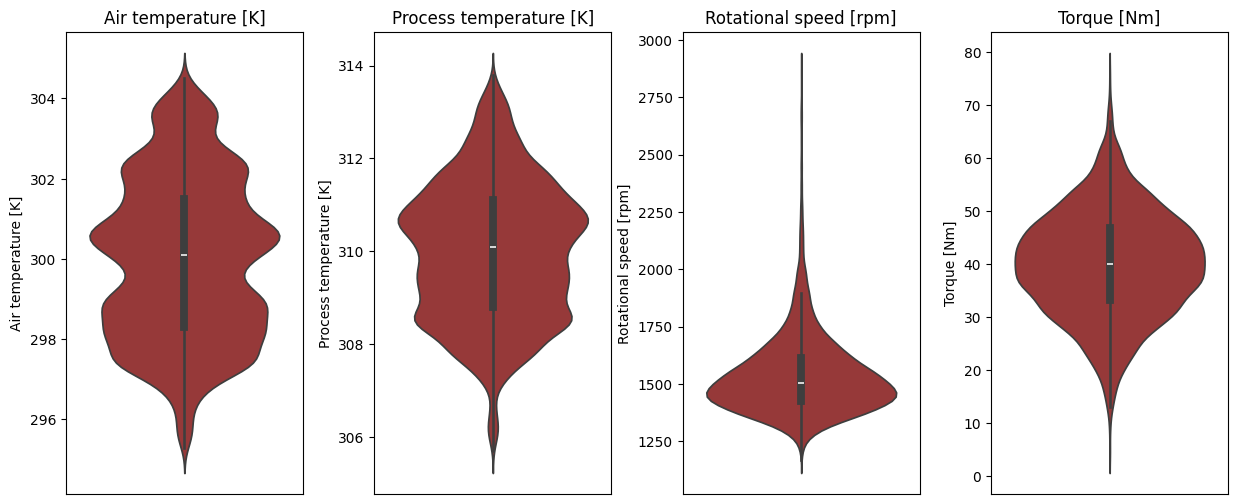

In [9]:
all_data=[df['Air temperature [K]'],df['Process temperature [K]'],df['Rotational speed [rpm]'],df['Torque [Nm]']]
plt.figure(figsize=(15,6))
title_data=['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]']
for i in range(4):
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.subplot(1,4,i+1)
    sns.violinplot(all_data[i],color='brown');
    plt.xticks([])
    plt.title(title_data[i],fontsize=12)


In [10]:
df[df['Rotational speed [rpm]']>2700]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
51,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
464,L47643,L,297.4,308.7,2874,4.2,118,1,0,0,1,0,0
848,L48027,L,296.4,307.4,2833,5.6,213,1,0,0,1,0,0
1096,L48275,L,296.9,307.5,2721,9.3,18,1,0,0,1,0,0
1392,L48571,L,298.9,310.2,2737,8.8,142,1,0,0,1,0,0
1785,L48964,L,298.3,308.0,2886,3.8,57,1,0,0,1,0,0
3370,L50549,L,301.5,310.9,2760,8.0,15,1,0,0,1,0,0
3868,M18727,M,302.7,311.6,2709,9.7,2,1,0,0,1,0,0
4297,L51476,L,301.8,310.2,2825,5.8,215,1,0,0,1,0,0


Ahora vamos a estudiar los diferentes tipos de fallo, que serán de estudio también para poder ser predichos por un modelo

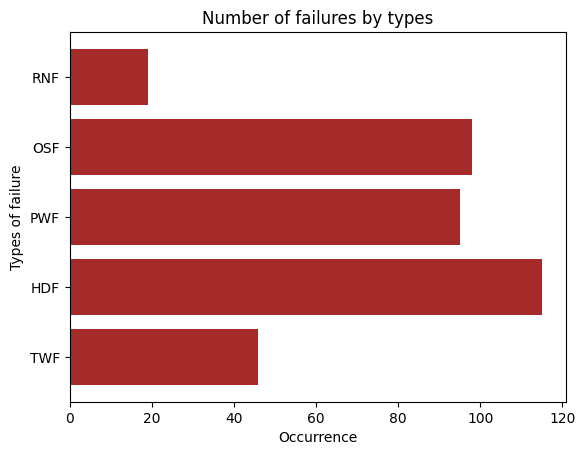

In [11]:
names=['TWF','HDF','PWF','OSF','RNF']
values=[df['TWF'][df['TWF']==1].sum(),df['HDF'][df['HDF']==1].sum(),df['PWF'][df['PWF']==1].sum(),df['OSF'][df['OSF']==1].sum(),df['RNF'][df['RNF']==1].sum()]

plt.barh(names,values,color='brown',)
plt.xlabel("Occurrence")
plt.ylabel("Types of failure")
plt.title("Number of failures by types")
plt.show()


In [12]:
df['TWF'][df['TWF']==1].sum()+df['HDF'][df['HDF']==1].sum()+df['PWF'][df['PWF']==1].sum()+df['OSF'][df['OSF']==1].sum()+df['RNF'][df['RNF']==1].sum()


373

In [13]:
df['Machine failure'][df['Machine failure']==1].sum()

339

In [14]:
df[(df['Machine failure']==0) & ((df['TWF']==1) | (df['HDF']==1) | (df['PWF']==1) | (df['OSF']==1) | (df['RNF']==1))]


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1222,M16081,M,297.0,308.3,1399,46.4,132,0,0,0,0,0,1
1303,L48482,L,298.6,309.8,1505,45.7,144,0,0,0,0,0,1
1749,H31162,H,298.4,307.7,1626,31.1,166,0,0,0,0,0,1
2073,L49252,L,299.6,309.5,1570,35.5,189,0,0,0,0,0,1
2560,L49739,L,299.3,309.0,1447,50.4,140,0,0,0,0,0,1
3066,M17925,M,300.1,309.2,1687,27.7,95,0,0,0,0,0,1
3453,H32866,H,301.6,310.5,1602,32.3,2,0,0,0,0,0,1
5472,L52651,L,302.7,312.3,1346,61.2,170,0,0,0,0,0,1
5490,L52669,L,302.6,312.1,1499,35.0,215,0,0,0,0,0,1


In [15]:
df[(df['Machine failure']==1) & (df['RNF']==1)]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
3612,L50791,L,301.7,310.9,1405,46.4,207,1,1,0,0,0,1


Dado que este modo de rotura es independiente a los parámetros usados, a la hora de predecir va a provocar ruido a nuestro modelo, por lo tanto se ha tomado la decisión de eliminar este tipo de fallo. Al ser aleatorios tendremos que asumirlos.

Chequeamos si hay modos de fallo que coincidan:

In [16]:
df[((df['TWF']==1) & (df['HDF']==1)) | ((df['TWF']==1) & (df['PWF']==1)) | ((df['TWF']==1) & (df['OSF']==1)) | ((df['HDF']==1) & (df['PWF']==1)) | ((df['HDF']==1) & (df['OSF']==1)) | ((df['PWF']==1) & (df['OSF']==1))]


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
1325,M16184,M,298.8,310.1,1243,74.5,194,1,0,0,1,1,0
1497,L48676,L,298.0,308.7,1268,69.4,189,1,0,0,1,1,0
3855,L51034,L,302.4,311.0,1338,67.6,194,1,0,0,1,1,0
3944,L51123,L,302.3,311.4,1333,66.7,205,1,0,0,1,1,0
4255,L51434,L,302.6,311.0,1284,68.0,114,1,0,1,1,0,0
4343,M19202,M,301.7,309.8,1284,68.2,111,1,0,1,1,0,0
4371,L51550,L,302.0,309.9,1308,57.6,197,1,0,1,0,1,0
4384,L51563,L,301.7,309.5,1298,65.5,229,1,0,1,0,1,0


In [17]:
df['Machine failure'][((df['TWF']==1) & (df['HDF']==1)) | ((df['TWF']==1) & (df['PWF']==1)) | ((df['TWF']==1) & (df['OSF']==1)) | ((df['HDF']==1) & (df['PWF']==1)) | ((df['HDF']==1) & (df['OSF']==1)) | ((df['PWF']==1) & (df['OSF']==1))].count()


23

In [18]:
(23/df['Machine failure'][df['Machine failure']==1].sum())*100

6.784660766961652

Lo que encontramos aquí es que hay diferentes casos (23) en los que se producen fallos mixtos, un 6,78%, lo que habrá que tener en consideración a la hora de predecir el tipo de fallo que ocurre

## FEATURE ENGINEERING

Eliminamos la columna de RNF

In [19]:
df=df.drop(columns='RNF')

Sacamos la variable potencia = torque x rot speed

In [20]:
#potencia_w = torque * (rpm * 2 * np.pi / 60) (para pasarlo a radianes)

df['Power [W]']=df['Torque [Nm]']*(df['Rotational speed [rpm]']*(2*np.pi/60))

Aplicamos dummies para poder tener en cuenta los valores de dureza de la herramienta: L (Low),M (Medium) y H (High)

In [21]:
#Probado también con los valores medios de las durezas de cada tipo de herramienta, pero se obtuvo peores resultados:
""" df['Type'].replace('L',600,inplace=True)
df['Type'].replace('M',1000,inplace=True)
df['Type'].replace('H',2000,inplace=True) """

" df['Type'].replace('L',600,inplace=True)\ndf['Type'].replace('M',1000,inplace=True)\ndf['Type'].replace('H',2000,inplace=True) "

In [22]:
df = pd.get_dummies(df, columns=['Type'])

In [23]:
df_aux=df[['Machine failure','TWF','HDF','PWF','OSF']]
df=df.drop(columns=['Machine failure','TWF','HDF','PWF','OSF'])
df['Machine failure']=df_aux['Machine failure']
df['TWF']=df_aux['TWF']
df['HDF']=df_aux['HDF']
df['PWF']=df_aux['PWF']
df['OSF']=df_aux['OSF']



In [24]:
df.head(2)

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power [W],Type_H,Type_L,Type_M,Machine failure,TWF,HDF,PWF,OSF
UDI,,,,,,,,,,,,,,,
1,M14860,298.1,308.6,1551,42.8,0,6951.590560,False,False,True,0,0,0,0,0
2,L47181,298.2,308.7,1408,46.3,3,6826.722724,False,True,False,0,0,0,0,0


Para la hora de predecir el modo de fallo mediante un modelo de clasificación, será mejor agruparlos en una columna los 4 tipos para tener un único target

## VISUALIZATION

Visualizamos en un primer momento todo el dataframe:

<Axes: >

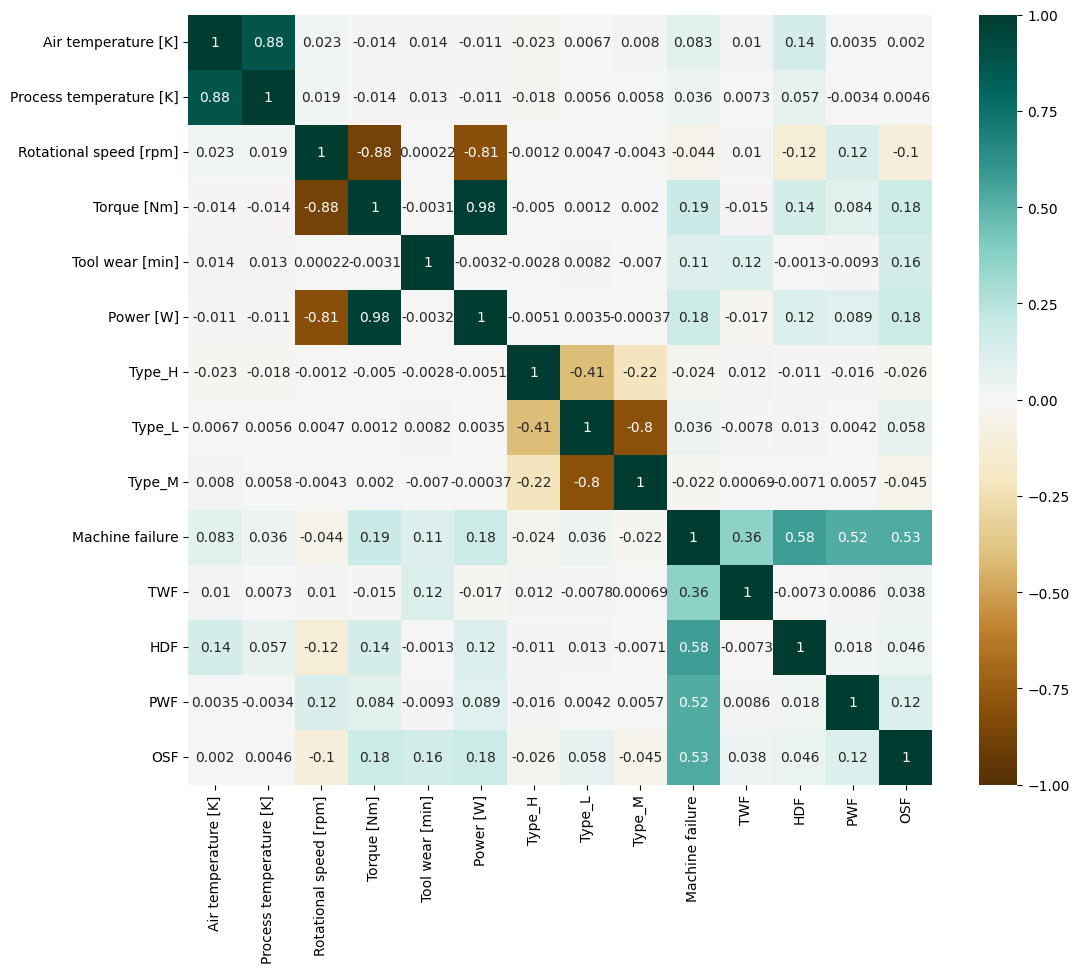

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='BrBG',vmin=-1,vmax=1)

### ***PRIMER CASO: ESTUDIO DE PREDICCIÓN DE MACHINE FAILURE:***


In [26]:
#sns.pairplot(df.drop(['TWF','HDF','PWF','OSF'],axis=1),hue='Machine failure')

A simple vista se puede ver como en algunas features como valores extremos provocan el fallo. Estas son Rotational speed, torque (tanto por debajo como por arriba) y por lógica la potencia (ya que se obtiene a partir de estas dos) y Tool wear que esta se da más cuando alcanza valores altos.

<Axes: >

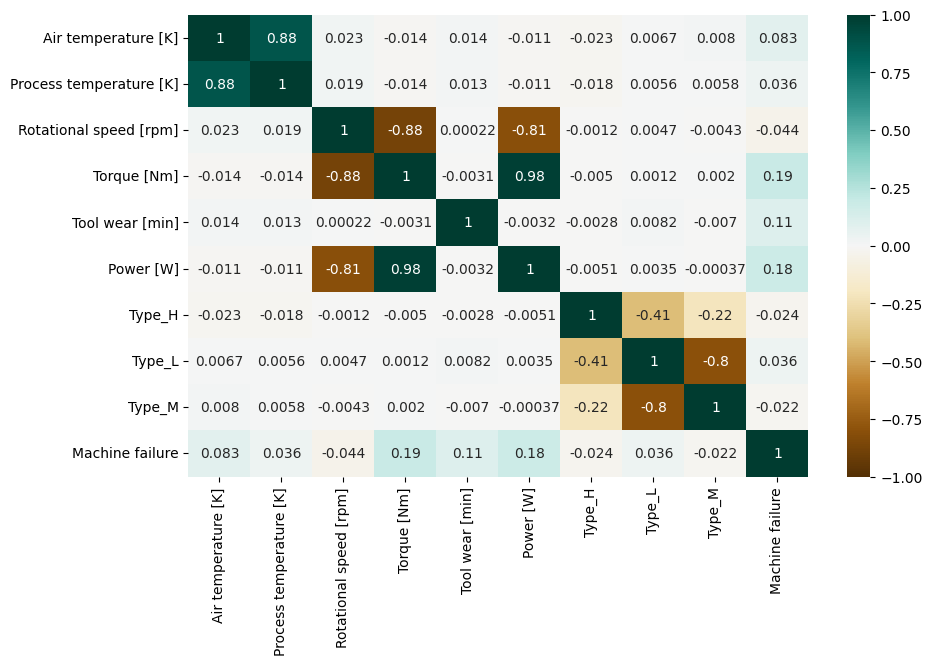

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['TWF','HDF','PWF','OSF'],axis=1).corr(numeric_only=True),annot=True,cmap='BrBG',vmin=-1,vmax=1)

No tenemos valores muy buenos de correlación para el target (Machine Failure), habrá que realizar una tarea de Feature engineering intensa para mejorar estas correlaciones

Vamos a ver lo que muestra la representación de Tool wear, para observar a qué tiempo se producen más fallos

<Axes: xlabel='Tool wear [min]', ylabel='Machine failure'>

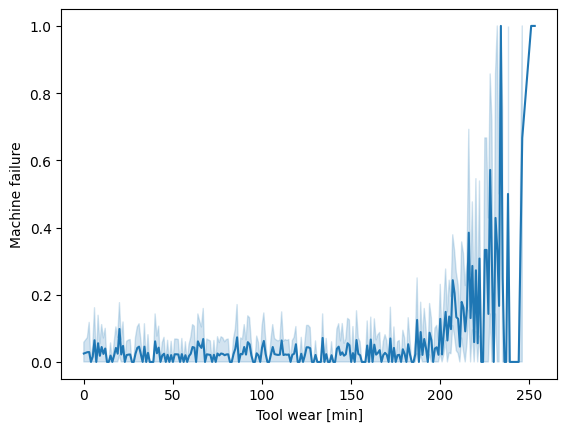

In [28]:
sns.lineplot(x=df['Tool wear [min]'],y=df['Machine failure'])

Aunque hay diferentes valores de 1 a lo largo del tiempo provocando la aletoriedad de la gráfica. Sin embargo, vemos claramente que en los valores altos es donde se producen la mayoría de fallos, lo cual será algo a tener muy en cuenta a la hora de predecir.

### ***SEGUNDO CASO: ESTUDIO DE PREDICCIÓN DE TIPO DE FALLO:***


Qué hago con los modos de fallo (sobre todo con los mixtos)? Es necesario hacer un modelo de machine?

Nos quedamos con el dataframe donde solo se haya prorducido fallo, ya que será con ese donde predeciremos el tipo:

In [29]:
df_type=df[df['Machine failure']==1]

In [30]:
df_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 51 to 9975
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               339 non-null    object 
 1   Air temperature [K]      339 non-null    float64
 2   Process temperature [K]  339 non-null    float64
 3   Rotational speed [rpm]   339 non-null    int64  
 4   Torque [Nm]              339 non-null    float64
 5   Tool wear [min]          339 non-null    int64  
 6   Power [W]                339 non-null    float64
 7   Type_H                   339 non-null    bool   
 8   Type_L                   339 non-null    bool   
 9   Type_M                   339 non-null    bool   
 10  Machine failure          339 non-null    int64  
 11  TWF                      339 non-null    int64  
 12  HDF                      339 non-null    int64  
 13  PWF                      339 non-null    int64  
 14  OSF                      339 

In [31]:
df_type.head()

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power [W],Type_H,Type_L,Type_M,Machine failure,TWF,HDF,PWF,OSF
UDI,,,,,,,,,,,,,,,
51,L47230,298.9,309.1,2861,4.6,143,1378.174809,False,True,False,1,0,0,1,0
70,L47249,298.9,309.0,1410,65.7,191,9700.923955,False,True,False,1,0,0,1,1
78,L47257,298.8,308.9,1455,41.3,208,6292.767165,False,True,False,1,1,0,0,0
161,L47340,298.4,308.2,1282,60.7,216,8149.019072,False,True,False,1,0,0,0,1
162,L47341,298.3,308.1,1412,52.3,218,7733.302588,False,True,False,1,0,0,0,1


In [32]:

import tensorflow as tf
from tensorflow import keras



In [33]:
# Definir variables de entrada y salida
X_t = df_type.drop(columns=['TWF', 'HDF', 'PWF', 'OSF', 'Machine failure', 'Product ID'])  # Features
y_t = df_type[['TWF', 'HDF', 'PWF', 'OSF']]  # Etiquetas

In [34]:
# Normalizar datos (opcional pero recomendable para redes neuronales)
scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)

In [35]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_t_scaled, y_t, test_size=0.2, random_state=42)

In [36]:
# Construcción del modelo en Keras
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(4, activation='sigmoid')  # 4 salidas para las etiquetas multietiqueta
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],

              )

In [38]:
earlystopping = keras.callbacks.EarlyStopping(patience=5)

In [39]:
# Entrenar el modelo
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2 ,
                    callbacks = [earlystopping]
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2709 - loss: 0.6708 - val_accuracy: 0.3091 - val_loss: 0.6088
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2766 - loss: 0.5876 - val_accuracy: 0.3091 - val_loss: 0.5478
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3081 - loss: 0.5267 - val_accuracy: 0.3273 - val_loss: 0.5064
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4493 - loss: 0.4894 - val_accuracy: 0.6545 - val_loss: 0.4593
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6893 - loss: 0.4248 - val_accuracy: 0.6727 - val_loss: 0.4095
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7636 - loss: 0.3546 - val_accuracy: 0.6727 - val_loss: 0.3685
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7327 - loss: 0.3384 - val_accuracy: 0.6727 - val_loss: 0.3246
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7772 - loss: 0.2574 - val_accuracy: 0.7091 - val_loss

<Axes: >

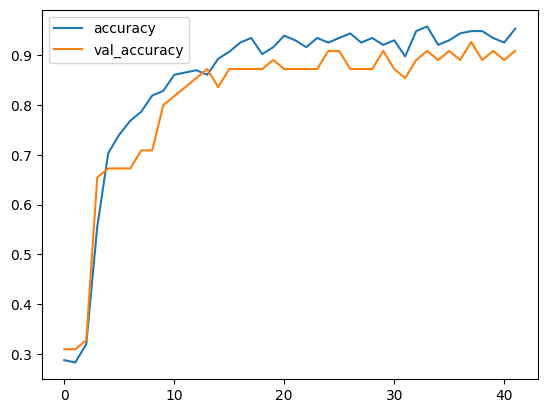

In [40]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()

In [41]:
# Predicciones
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [42]:
np.round(y_pred,2)

array([[0.  , 0.  , 0.02, 1.  ],
       [0.08, 0.94, 0.  , 0.01],
       [0.01, 0.76, 0.01, 0.9 ],
       [0.99, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.01, 0.19, 0.02, 0.98],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.26, 0.99],
       [0.98, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.01, 0.82, 0.01, 0.82],
       [0.  , 0.01, 0.71, 0.94],
       [0.  , 0.99, 0.01, 0.27],
       [0.  , 1.  , 0.01, 0.  ],
       [0.  , 0.94, 0.05, 0.74],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 1.  ],
       [0.01, 0.  , 0.19, 0.  ],
       [0.  , 0.  , 0.01, 1.  ],
       [0.99, 0.  , 0.  , 0.  ],
       [0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.99, 0.03, 0.  ],
       [0.  , 1.  , 0.  , 0.01],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.98, 0.02, 0.  ],
       [0.03, 0.98, 0.  , 0.  ],
       [0.  , 0.98, 0.02, 0.  ],
       [0.96, 0.  , 0.  , 0.03],
       [0.

In [43]:
y_pred_binary = (y_pred > 0.5).astype(int)  # Convertir probabilidades en etiquetas binarias
y_pred_binary


array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 0],
       [1, 0,

In [44]:
# Evaluación
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.78      1.00      0.88        21
           2       0.86      1.00      0.92        12
           3       1.00      0.87      0.93        23

   micro avg       0.89      0.93      0.91        71
   macro avg       0.91      0.93      0.91        71
weighted avg       0.91      0.93      0.91        71
 samples avg       0.90      0.90      0.89        71



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vamos a realizar una matriz de confusión para ver los resultados más claramente:


In [45]:
y_test_lista=np.array(y_test.values)

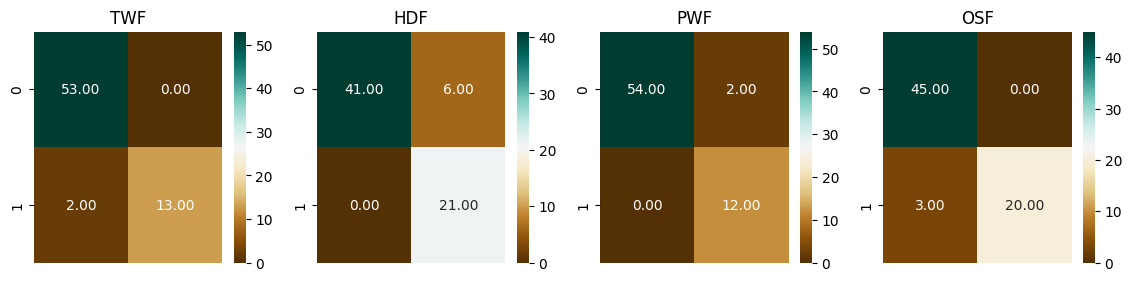

In [46]:
plt.figure(figsize=(14,3))
title_data=['TWF', 'HDF', 'PWF', 'OSF']

for i in range(y_pred_binary.shape[1]):
  y_pred_binary_clas=list()
  y_test_lista_clas=list()
  for j in range(y_pred_binary.shape[0]):
    if y_pred_binary[j][i]==1:
      y_pred_binary_clas.append(1)
    else:
      y_pred_binary_clas.append(0)
    if y_test_lista[j][i]==1:
      y_test_lista_clas.append(1)
    else:
      y_test_lista_clas.append(0)
  #plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.subplot(1,4,i+1)
  sns.heatmap(confusion_matrix(y_test_lista_clas, y_pred_binary_clas), annot=True, cmap='BrBG', fmt=".2f")
  plt.xticks([])
  plt.title(title_data[i],fontsize=12)

In [47]:
#En el caso de hacer fallos excluyentes
#confusion_matrix(y_test.values.argmax(axis=1), y_pred_binary.argmax(axis=1))

In [48]:
#En el caso de hacer fallos excluyentes
#sns.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred_binary.argmax(axis=1),normalize='true'), annot=True, cmap='BrBG', fmt=".2f")

In [50]:
model.save('model_types.keras')